In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/abstract/sample_submission.csv
/kaggle/input/abstract/train.csv
/kaggle/input/abstract/test.csv
/kaggle/input/d/datasets/nithinkyatham/ulmfit-predictions/ulmfit_predictions.csv
/kaggle/input/ulmfit-model/model


In [2]:
trainData = pd.read_csv('/kaggle/input/abstract/train.csv', sep=',', header="infer")
# testData = pd.read_csv('/kaggle/input/abstract/test.csv', sep = ',', header = "infer")
# testLabels = pd.read_csv('/kaggle/input/abstract/sample_submission.csv', sep = ',', header = "infer")

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(trainData, train_size=0.9, random_state=34)
X_train, X_test, y_train, y_test  = train_test_split(train_data.ABSTRACT.values, train_data.iloc[:,3:].values,train_size=0.7, random_state=34)

mlb = MultiLabelBinarizer()
mlb.fit_transform([{'Computer Science'}, {'Physics'}, {'Mathematics'}, {'Statistics'}, {'Quantitative Biology'}, {'Quantitative Finance'}])
text_labels = mlb.inverse_transform(y_train)
text_labels_str= []

for labels in text_labels:
    text_labels_str.append(list(labels))

# Implementation of ULMFIT In FastAI

In [3]:
from sklearn.preprocessing import MultiLabelBinarizer
import re
from fastai.text.all import *
from sklearn.model_selection import train_test_split
import spacy
! python -m spacy download en_core_web_sm
# ! python -m spacy download en_core_web_lg

# from fastai.core. import 
# import pandas as pd
# import numpy as np
# from functools import partial

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 15.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.2.0
    Uninstalling typing_extensions-4.2.0:
      Successfully uninstalled typing_extensions-4.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires absl-py~=0.10, but you have absl-py 1.0.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.4 requires wrapt~=1.12.1, but you have wrapt 1.14.1 which is incompatible.
tensorflow-transform 1.8.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2

In [4]:
class ULMFit:
    def __init__(self):
        self.trainData = pd.read_csv('/kaggle/input/abstract/train.csv', sep=',', header="infer")
        self.trainData_cp = self.trainData.copy()
        self.X = 'ABSTRACT'
        self.Y = [3,4,5,6,7,8]
        self.BATCH_SIZE = 16
        self.N_EPOCHS = [3, 1]
        self.lr= [1e-4, 2e-2, slice(1e-2/(2.6**4),1e-2), slice(5e-3/(2.6**4),5e-3), slice(1e-3/(2.6**4),1e-3)]
        self.layer_unfreeze = [-2, -3]
        self.mlb = MultiLabelBinarizer()
        
    def preprocess(self):
        self.trainData_cp[self.X] = self.trainData[self.X].apply(lambda x: re.sub("\n"," ",x))
        train_data, val_data = train_test_split(self.trainData_cp, train_size=0.85, random_state=34)
        X_train, X_test, y_train, y_test  = train_test_split(train_data[self.X], train_data.iloc[:,self.Y].values,train_size=0.7, random_state=34)
        self.mlb.fit_transform([{'Computer Science'}, {'Physics'}, {'Mathematics'}, {'Statistics'}, {'Quantitative Biology'}, {'Quantitative Finance'}])
        text_labels = self.mlb.inverse_transform(y_train)
        text_labels_str= []

        for labels in text_labels:
            text_labels_str.append(list(labels))
            
        return X_train, X_test, y_train, y_test, val_data, text_labels_str
    
    def lm_finetuning(self, X_train, text_labels_str):
        dls_lm = pd.DataFrame({'text': X_train, 'label': text_labels_str})

        # This will automatically process all text and split and add special tokens like xxbos - to indicate beginning of text, xxmaj - indicate next word was capitalized 
        data_lm = TextDataLoaders.from_df(dls_lm ,is_lm=True,label_delim=',', valid_pct=0.1, bs=self.BATCH_SIZE)
        
        # A pretrained language model is trying to learn from the above processed data
        learn = language_model_learner(data_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], wd=0.1).to_fp16()
        learn.fit_one_cycle(1, 1e-2)

        learn.save('1epoch')
        
        learn = learn.load('1epoch')
        
        learn.unfreeze()
        learn.fit_one_cycle(self.N_EPOCHS[0], self.lr[0])
        
        learn.save_encoder('finetuned')
        
        return learn, dls_lm, data_lm
    
    def cls_finetuning(self, learn, dls_lm, data_lm):
        dls_clas = TextDataLoaders.from_df(dls_lm,text_col=0, valid_pct=0.2, y_block = MultiCategoryBlock,label_col=1,vocab=data_lm.train_ds.vocab, bs=self.BATCH_SIZE)

        learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=[accuracy_multi, Perplexity(), F1ScoreMulti(average='samples')], cbs=ShowGraphCallback())
        
        learn = learn.load_encoder('finetuned')
        
        learn.fit_one_cycle(self.N_EPOCHS[1], self.lr[1], cbs=[ShowGraphCallback()])
        
        learn.freeze_to(self.layer_unfreeze[0])
        learn.fit_one_cycle(self.N_EPOCHS[1], self.lr[2], cbs=[ShowGraphCallback()])
        
        learn.freeze_to(self.layer_unfreeze[1])
        learn.fit_one_cycle(self.N_EPOCHS[1], self.lr[3], cbs=[ShowGraphCallback()])
        
        learn.unfreeze()
        learn.fit_one_cycle(self.N_EPOCHS[1], self.lr[4], cbs=[ShowGraphCallback()])
        
        return learn, dls_clas
        
        

# Class invokation

In [ ]:
ulm = ULMFit()

# Preprocessing data

In [ ]:
X_train, X_test, y_train, y_test, val_data, text_labels_str = ulm.preprocess()

# Language Model Fine-tuning

In [ ]:
lang_model, data_df, data_lm = ulm.lm_finetuning(X_train, text_labels_str)

# Classifier Training & Fine-tuning

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.523905,4.238659,0.301337,69.314835,12:32


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.189505,4.125666,0.310971,61.909035,12:14
1,4.119410,4.076576,0.315722,58.943287,12:29
2,4.104539,4.067503,0.316402,58.410954,12:43


epoch,train_loss,valid_loss,accuracy_multi,perplexity,f1_score,time
0,0.244063,0.183155,0.923247,1.201001,0.815244,00:57


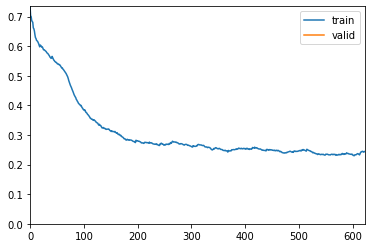

epoch,train_loss,valid_loss,accuracy_multi,perplexity,f1_score,time
0,0.231710,0.184305,0.922779,1.202382,0.814429,01:06


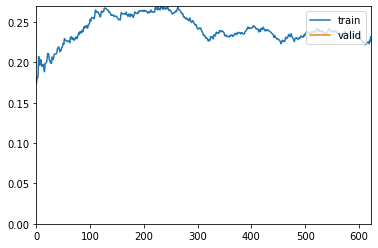

epoch,train_loss,valid_loss,accuracy_multi,perplexity,f1_score,time
0,0.218495,0.173764,0.928791,1.189775,0.829780,01:37


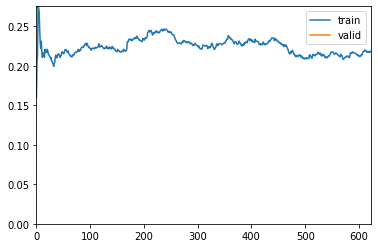

epoch,train_loss,valid_loss,accuracy_multi,perplexity,f1_score,time
0,0.194663,0.173368,0.930528,1.189304,0.834990,02:06


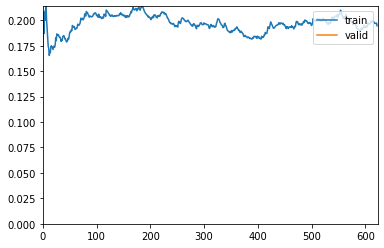

In [5]:
classifier_model, dls_clas = ulm.cls_finetuning(lang_model, data_df, data_lm)

# Model Predictions

In [6]:
# dls_lm = pd.DataFrame({'text': X_train, 'label': text_labels_str})
# data_lm = TextDataLoaders.from_df(dls_lm ,is_lm=True,label_delim=',', valid_pct=0.1, bs=16)
# dls_clas = TextDataLoaders.from_df(dls_lm,text_col=0, valid_pct=0.2, y_block = MultiCategoryBlock,label_col=1,vocab=data_lm.train_ds.vocab, bs=16)

# import torch
# model = torch.load('/kaggle/input/ulmfit-model/model')

def prediction(dls_clas, classifier_model, X_test):
    test_dl = dls_clas.test_dl(X_test)
    preds, _, classes = classifier_model.get_preds(dl=test_dl, with_decoded=True)
    out_list = []
    for pred in preds.numpy():
        in_list = []
        for prob in pred:
            if prob >0.5:
                in_list.append(1)
            else:
                in_list.append(0)
        out_list.append(in_list)
        
    prediction_df = pd.DataFrame({
    'id': test_dl.get_idxs(),
    'pred_prob': list(preds.numpy()),
    'predictions':out_list
        })

#     prediction_df.to_csv('ulmfit_predictions')
    
    return prediction_df, out_list

pred_df, predlist = prediction(dls_clas, classifier_model, X_test)

# Metrics

In [23]:
from sklearn.metrics import precision_recall_fscore_support, multilabel_confusion_matrix
cm = multilabel_confusion_matrix(y_test[:944], predlist[:944])
print('multilabel_confusion_matrix \n', cm)

multilabel_confusion_matrix 
 [[[520  59]
  [ 57 308]]

 [[655  16]
  [ 43 230]]

 [[644  41]
  [ 45 214]]

 [[669  36]
  [ 61 178]]

 [[908   6]
  [ 18  12]]

 [[928   4]
  [  6   6]]]


In [18]:
precision, recall, fscore ,_= precision_recall_fscore_support(y_test[:944], predlist[:944])
print('precision', precision)
print('Recall', recall)
print('F1 score', fscore)

precision [0.83923706 0.93495935 0.83921569 0.8317757  0.66666667 0.6       ]
Recall [0.84383562 0.84249084 0.82625483 0.74476987 0.4        0.5       ]
F1 score [0.84153005 0.88631985 0.83268482 0.78587196 0.5        0.54545455]


# Sentence segmentation and inference on the sentence

In [52]:
import torch

def sentenceSegmentation(text):
    spacy_sm = spacy.load('en_core_web_sm')
#     spacy_lg = spacy.load('en_core_web_lg')
    sent_list = []
    for sent in spacy_sm(text).sents:
        sent_list.append(str(list(sent)))
    return sent_list

def sent_predict(dls_clas, model, text):
    
    sent_list = sentenceSegmentation(text)
    prediction_df, prediction_list = prediction(dls_clas, model, sent_list)                 
    return prediction_df, prediction_list

In [63]:
# dls_lm = pd.DataFrame({'text': X_train, 'label': text_labels_str})
# data_lm = TextDataLoaders.from_df(dls_lm ,is_lm=True,label_delim=',', valid_pct=0.1, bs=16)
# dls_clas = TextDataLoaders.from_df(dls_lm,text_col=0, valid_pct=0.2, y_block = MultiCategoryBlock,label_col=1,vocab=data_lm.train_ds.vocab, bs=16)

# model = torch.load("/kaggle/input/ulmfit-model/model")

pred_df, pred_list = sent_predict(dls_clas, model, X_test[3])
pred_list, y_test[3]

([[0, 0, 1, 0, 0, 0],
  [1, 0, 0, 0, 0, 0],
  [0, 0, 1, 0, 0, 0],
  [1, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0]],
 array([1, 0, 0, 0, 0, 0]))

In [66]:
test_dl = dls_clas.test_dl(X_test)
preds, _, classes = classifier_model.get_preds(dl=test_dl, with_decoded=True)

df = pd.DataFrame({
    'id': test_dl.get_idxs(),
    'pred_prob': list(preds.numpy()),
    'predictions':out_list
})

df.to_csv('ulmfit_predictions')


In [21]:
from sklearn.metrics import f1_score
f1_score(y_test[:944], predlist[:944],average="samples")

0.8329096045197739

In [19]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test[:944], predlist[:944])

0.6896186440677966

In [82]:
# import torch
# torch.save(classifier_model, 'model')
# model = torch.load('model')
# model.get_preds(dl=test_dl, with_decoded=True)
# test_dl

# We can use this Language Model for generating sentences as it is trained to guess what next word is.

In [ ]:
TEXT = "We investigate the formation and early evolution of star clusters assuming"
N_WORDS = 50
N_SENTENCES = 3
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]

print("\n".join(preds))